## Prediction Model

### Import libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
from utils.preparedata import PrepareData
# Pipeline and transformations
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 
# Regressors
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
#Metrics
from sklearn import metrics

import warnings 
warnings.filterwarnings('ignore')


In [2]:
# Import dataset
parser= lambda x: pd.to_datetime(x)
df = pd.read_csv('http://huy302.github.io/interview_dataset.csv', parse_dates=['date on production'], date_parser=parser)

In [3]:
# Let's separate dataset in train and test
X = df.drop('production', axis=1)
y = df['production']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Pipeline

In [4]:
num_columns = ['azimuth', 'md (ft)', 'tvd (ft)', 'well spacing', 'porpoise deviation', 
        'porpoise count', 'shale footage', 'acoustic impedance', 'log permeability', 'porosity', 
        'poisson ratio', 'toc', 'vcl', 'p-velocity', 's-velocity', 'youngs modulus', 'isip', 'pump rate',
       'total number of stages', 'proppant volume', 'proppant fluid ratio']

num_transform = MinMaxScaler()

cat_columns = ['year on production', 'month on production']

cat_transform = OneHotEncoder()

column_transform = ColumnTransformer(
    transformers=[
        ("num", num_transform, num_columns),
        ("cat", cat_transform, cat_columns)
        ]
    )

In [5]:
pipe = Pipeline(
    steps=[
        ('features', PrepareData()),
        ('col_transform', column_transform),
        ('regressor', LinearRegression())
    ]
)

grid_param = [
    {
        "regressor": [XGBRegressor()]
    },
    {
        "regressor": [RandomForestRegressor()]
    },
    {
        "regressor": [BaggingRegressor()]
    }   
]

### Evalaute models

In [7]:
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0, n_jobs=-1)
best_model = gridsearch.fit(X_train, y_train) 

In [8]:
best_model.best_estimator_

Pipeline(steps=[('features', PrepareData()),
                ('col_transform',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['azimuth', 'md (ft)',
                                                   'tvd (ft)', 'well spacing',
                                                   'porpoise deviation',
                                                   'porpoise count',
                                                   'shale footage',
                                                   'acoustic impedance',
                                                   'log permeability',
                                                   'porosity', 'poisson ratio',
                                                   'toc', 'vcl', 'p-velocity',
                                                   's-velocity',
                                                   'youngs modulus', 'isip',
                                                   'pump rate',
                                                   'total number of stages',
                                                   'proppant volume',
                                                   'proppant fluid ratio']),
                                                 ('cat', OneHotEncoder(),
                                                  ['year on production',
                                                   'month on production'])])),
                ('regressor', RandomForestRegressor())])

In [36]:
print('R2: {:.2f}'.format(best_model.score(X_test, y_test)))

R2: 0.67


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

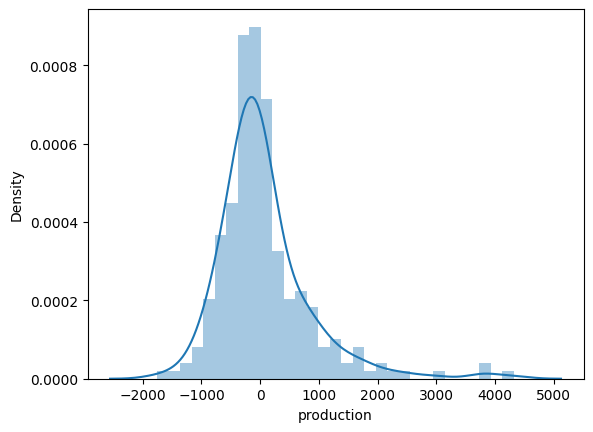

In [11]:
y_pred = best_model.predict(X_test)
sns.distplot(y_test - y_pred)
plt.show()

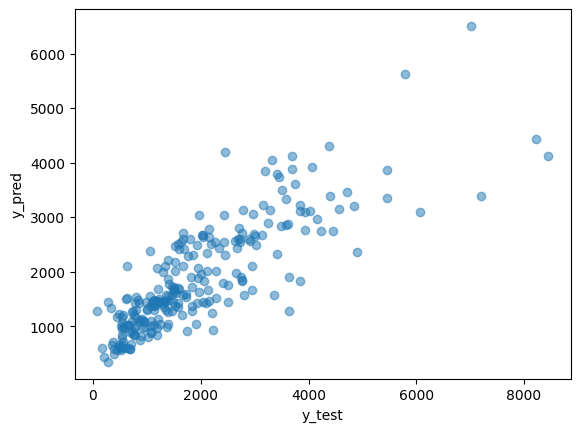

In [12]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [13]:
print("MAE :  {:.2f}".format(metrics.mean_absolute_error(y_test, y_pred)))
print("RMSE: {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print("MSE :  {:.2f}".format(metrics.mean_squared_error(y_test, y_pred)))


MAE :  531.33
RMSE: 806.50
MSE :  650439.41


### Hyperparameter Tuning

In [14]:
from sklearn.model_selection import RandomizedSearchCV

In [21]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]
max_depth = [int(x) for x in np.linspace(3, 30, num=10)] + [None]
min_samples_split  = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

random_grid = {
               'regressor__n_estimators': n_estimators,
               'regressor__max_depth': max_depth,
               'regressor__min_samples_split': min_samples_split,
               'regressor__min_samples_leaf': min_samples_leaf
                }

In [22]:
gbr_random = RandomizedSearchCV(estimator=best_model.best_estimator_, param_distributions=random_grid, 
                                scoring='neg_mean_squared_error', n_iter=10, cv=5, n_jobs=-1, verbose=0)

In [23]:
gbr_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('features', PrepareData()),
                                             ('col_transform',
                                              ColumnTransformer(transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['azimuth',
                                                                                'md '
                                                                                '(ft)',
                                                                                'tvd '
                                                                                '(ft)',
                                                                                'well '
                                                                                'spacing',
                                                                                'porpoise '
                                                                                'deviation',
                                                                                'porpoise '
                                                                                'count',
                                                                                'shale '
                                                                                'footage',
                                                                                'acoustic '
                                                                                'impedance',
                                                                                'log '
                                                                                'permeability',
                                                                                'porosity',
                                                                                'poisson '
                                                                                'ratio',
                                                                                'toc',
                                                                                'vcl',
                                                                                'p-velocity',...
                                                                                'on '
                                                                                'production'])])),
                                             ('regressor',
                                              RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions={'regressor__max_depth': [3, 6, 9, 12,
                                                                 15, 18, 21, 24,
                                                                 27, 30, None],
                                        'regressor__min_samples_leaf': [1, 2, 5,
                                                                        10],
                                        'regressor__min_samples_split': [2, 5,
                                                                         10, 15,
                                                                         100],
                                        'regressor__n_estimators': [100, 200,
                                                                    300, 400,
                                                                    500, 600,
                                                                    700, 800,
                                                                    900, 1000,
                                                                    1100,
                                                                    1200]},
                   scoring='neg_mean_squared_error')

In [24]:
gbr_random.best_params_

{'regressor__n_estimators': 900,
 'regressor__min_samples_split': 2,
 'regressor__min_samples_leaf': 1,
 'regressor__max_depth': 24}

In [25]:
predictions = gbr_random.predict(X_test)

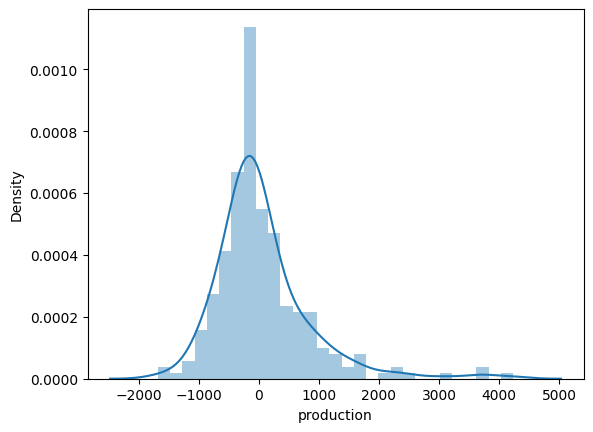

In [32]:
plt.figure()
sns.distplot(y_test - predictions)
plt.show()

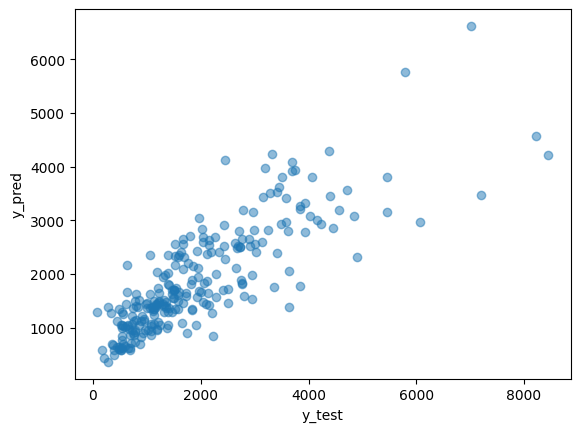

In [31]:
plt.figure()
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [29]:
print("MAE :  {:.2f}".format(metrics.mean_absolute_error(y_test, predictions)))
print("RMSE: {:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))
print("MSE :  {:.2f}".format(metrics.mean_squared_error(y_test, predictions)))

MAE :  532.16
RMSE: 803.20
MSE :  645132.42


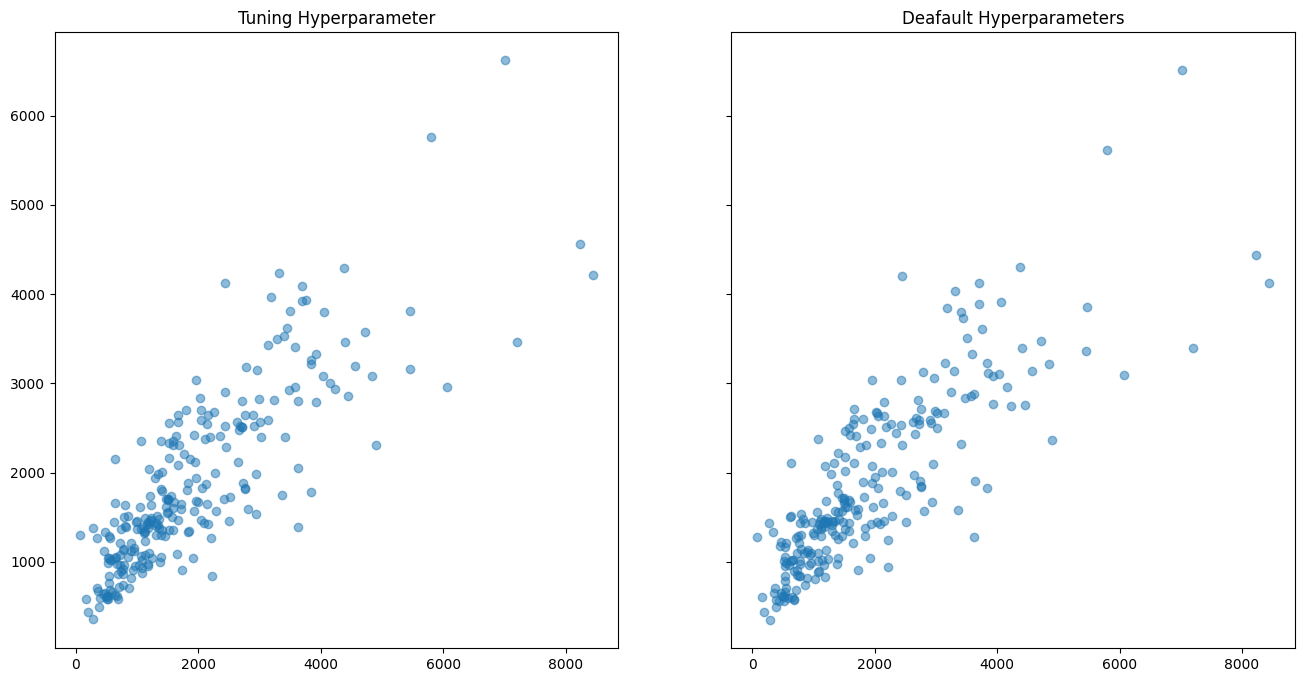

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(16,8), sharey=True)
axs[0].scatter(y_test, predictions, alpha=0.5)
axs[0].set_title("Tuning Hyperparameter")
axs[1].scatter(y_test, y_pred, alpha=0.5)
axs[1].set_title("Deafault Hyperparameters")
plt.show()

Isn't a great difference between default params and tunning params, this must be due to there's little information for high productions and the model can't learn about this cases.

### Save the model

In [33]:
import pickle

In [35]:
# open a file
file = open('models/model.pkl', 'wb')

# dump information
pickle.dump(gbr_random, file)